Podpisany: Stefan Hajdu

Potrebne balicky:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp
from mpmath import *

Pomocne funkcie pre kreslenie grafov

In [2]:
def plot_fn(f, symbol, x_axis=(-10, 10, 100)):
    """
    Args:
        f: funkcia, ktorej koren hladame
        symbol: premenna, je to x v f(x)
        x_axis: tuple, obsahuje rozsah intervalu a pocet dielikov
    """
    f = sp.lambdify(symbol, f)
    x = np.linspace(x_axis[0], x_axis[1], x_axis[2])
    y = f(x)

    # clear current plot
    plt.clf()

    plt.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
    plt.axvline(x=0, c="black")
    plt.axhline(y=0, c="black")
    plt.ylabel("y")
    plt.xlabel("x")
    plt.plot(x,y)
    plt.show()

def plot_fn_diff(f, symbol, x_axis=(-10, 10, 100)):
    """
    Args:
        f: funkcia, ktorej koren hladame
        symbol: premenna, je to x v f(x)
        x_axis: tuple, obsahuje rozsah intervalu a pocet dielikov
    """
    f = f.diff(symbol)
    f = sp.lambdify(symbol, f)
    x = np.linspace(x_axis[0], x_axis[1], x_axis[2])
    y = f(x)

    # clear current plot
    plt.clf()

    plt.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
    plt.axvline(x=0, c="black")
    plt.axhline(y=0, c="black")
    plt.ylabel("y")
    plt.xlabel("x")
    plt.plot(x,y)
    plt.show()

def plot_fn_system(_vars, _funcs, x_axis=(-10, 10), y_axis=(-10, 10), bins=100):
    """
    Args:
        _vars: dict(str, int), tabulka neznamych a ich pociatocnych (x0, y0) hodnot
        _funcs: list(str), zoznam sustavy funckii v tvare f(x,y) = 0
        x_axis: tuple, obsahuje rozsah intervalu a pocet dielikov
    """
    xy_sym = list(_vars.keys())
    _funcs = sp.sympify(_funcs)
    x = np.linspace(x_axis[0], x_axis[1], bins)
    y = np.linspace(y_axis[0], y_axis[1], bins)
    f1 = sp.lambdify(xy_sym, _funcs[0])
    f2 = sp.lambdify(xy_sym, _funcs[1])
    X, Y = np.meshgrid(x,y)
    val1 = f1(X, Y)
    val2 = f2(X, Y)

    # clear current plot
    plt.clf()

    plt.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
    plt.axvline(x=0, c="black")
    plt.axhline(y=0, c="black")
    plt.ylabel("y")
    plt.xlabel("x")
    plt.contour(X, Y, val1, [0])
    plt.contour(X, Y, val2, [0])
    plt.show()

Numericke funkcie:
- iteracne schemy su oznacene komentarom
- funckia na konci dosadi hodnotu najpresnejsieho korena do predpisu funckie (vykona sa skuska spravnosti)

In [3]:
def newtonova_metoda(f, symbol, x=[1], tolerancia=10e-10, r=10):
    """
    Args:
        f: funkcia, ktorej koren hladame
        symbol: premenna, je to x v f(x)
        x: zoznam, ktory obsahuje approximaciu korenov, v prvej iteracii obsahuje bod x0
        tolerancia: float, presnost vysledku
        r: int, pocet iteracii/opakovani algoritmu
    """

    # zderivuj funkciu
    d_f = f.diff(symbol)
    
    f = sp.lambdify(symbol, f)
    d_f = sp.lambdify(symbol, d_f)

    results = pd.DataFrame({'i': pd.Series(dtype='int'),
                   'x(i)': pd.Series(dtype='float'),
                   '|x(i+1)-x(i)|': pd.Series(dtype='float')})

    for i in range(r):
        # ITERACNA SCHEMA
        x_plus_1 = x[i] - (f(x[i]) / d_f(x[i]))
        x.append(x_plus_1)
        relative_err = abs(x[i]-x[i-1])
        results.loc[len(results)] = [i, x[i], relative_err]
        if relative_err < tolerancia:
            break
    
    print(results)
    print(f'\nSKUSKA: {f(x[-1]):.16f}')

def inv_sustava_rovnic(_vars, _funcs, tolerancia=10e-16, r=10):
    """
    Args:
        _vars: dict(str, int), tabulka neznamych a ich pociatocnych (x0, y0) hodnot
        _funcs: list(str), zoznam sustavy funckii v tvare f(x,y) = 0
        tolerancia: float, presnost vysledku
        r: int, pocet iteracii/opakovani algoritmu
    """
    xy_sym = list(_vars.keys())
    xy_val = list(_vars.values())
    _funcs = sp.sympify(_funcs)
    J = sp.Matrix(_funcs).jacobian(xy_sym)
    
    J = sp.lambdify(xy_sym, J)
    f1 = sp.lambdify(xy_sym, _funcs[0])
    f2 = sp.lambdify(xy_sym, _funcs[1])

    results = pd.DataFrame({'x(i)': pd.Series(dtype='float'),
                            'y(i)': pd.Series(dtype='float'),
                            'err': pd.Series(dtype='float')})

    xy_mat = [[xy_val[0]], [xy_val[1]]]
    for i in range(r):
        xy_func = [[f1(xy_mat[0][0], xy_mat[1][0])], [f2(xy_mat[0][0], xy_mat[1][0])]]
        # ITERACNA SCHEMA, @ JE DOT PRODUCT
        xy_next = np.array(xy_mat) - np.linalg.inv(J(xy_mat[0][0], xy_mat[1][0])) @ np.array(xy_func)
        
        err = max(abs(xy_next[0][0]-xy_mat[0][0]), abs(xy_next[1][0]-xy_mat[1][0]))
        results.loc[i] = [xy_mat[0][0], xy_mat[1][0], err]
        if err < tolerancia:
            break

        xy_mat[0][0] = xy_next[0][0]
        xy_mat[1][0] = xy_next[1][0]

    print(results)
    print(f'SKUSKA F1: {f1(xy_mat[0][0], xy_mat[1][0]):.16f}')
    print(f'SKUSKA F2: {f2(xy_mat[0][0], xy_mat[1][0]):.16f}')
    print('\n')

def chord_sustava_rovnic(_vars, _funcs, tolerancia=10e-16, r=10):
    """
    Args:
        _vars: dict(str, int), tabulka neznamych a ich pociatocnych (x0, y0) hodnot
        _funcs: list(str), zoznam sustavy funckii v tvare f(x,y) = 0
        tolerancia: float, presnost vysledku
        r: int, pocet iteracii/opakovani algoritmu

    """
    xy_sym = list(_vars.keys())
    xy_val = list(_vars.values())
    _funcs = sp.sympify(_funcs)
    J = sp.Matrix(_funcs).jacobian(xy_sym)
    
    J = sp.lambdify(xy_sym, J)
    J_fixed = np.linalg.inv(J(xy_val[0], xy_val[1]))
    f1 = sp.lambdify(xy_sym, _funcs[0])
    f2 = sp.lambdify(xy_sym, _funcs[1])

    results = pd.DataFrame({'x(i)': pd.Series(dtype='float'),
                            'y(i)': pd.Series(dtype='float'),
                            'err': pd.Series(dtype='float')})

    xy_mat = [[xy_val[0]], [xy_val[1]]]
    for i in range(r):
        xy_func = [[f1(xy_mat[0][0], xy_mat[1][0])], [f2(xy_mat[0][0], xy_mat[1][0])]]
        # ITERACNA SCHEMA
        xy_next = np.array(xy_mat) - J_fixed @ np.array(xy_func)
        
        err = max(abs(xy_next[0][0]-xy_mat[0][0]), abs(xy_next[1][0]-xy_mat[1][0]))
        results.loc[i] = [xy_mat[0][0], xy_mat[1][0], err]
        if err < tolerancia:
            break

        xy_mat[0][0] = xy_next[0][0]
        xy_mat[1][0] = xy_next[1][0]

    print(results)
    print(f'SKUSKA F1: {f1(xy_mat[0][0], xy_mat[1][0]):.16f}')
    print(f'SKUSKA F2: {f2(xy_mat[0][0], xy_mat[1][0]):.16f}')
    print('\n')



## Priklad 1

### 1. Separacia korenov na [-10, 10]

A. predpis


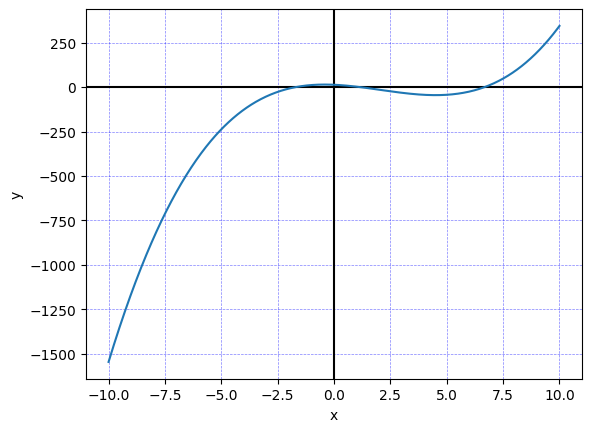

B. separacia najmensieho korena


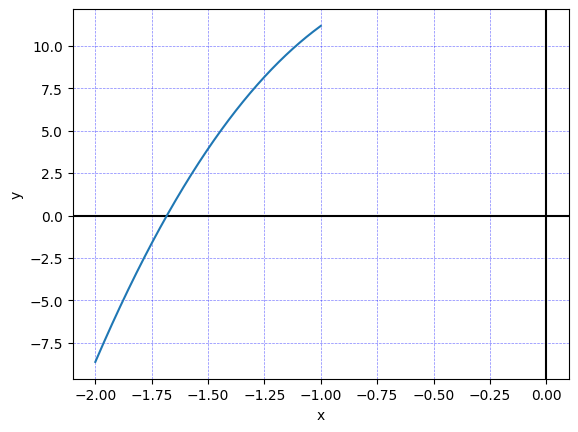

C. separacia stredneho korena


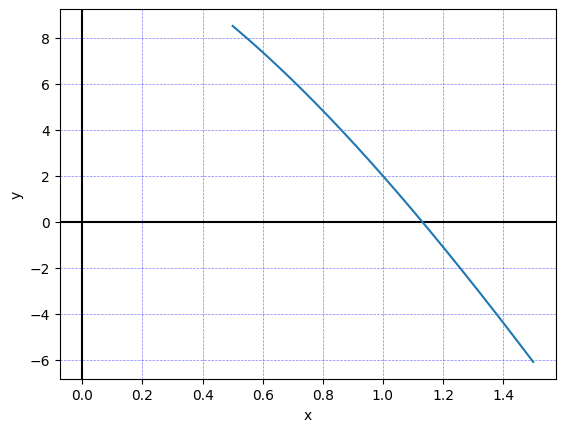

D. separacia najvacsieho korena


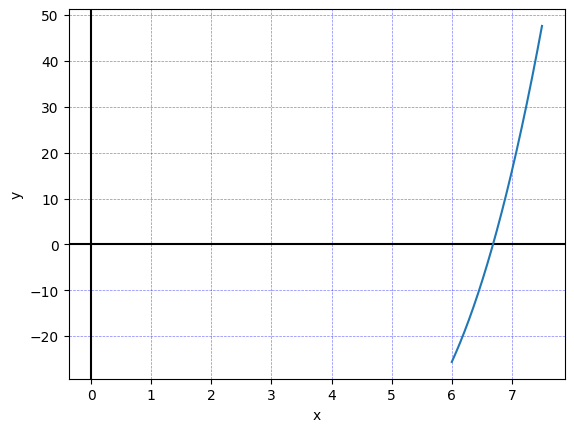

In [4]:
print('A. predpis')
x = sp.Symbol('x')
f = 12.723489 - 5.589489*x - 6.134*x**2 + x**3
plot_fn(f, x, x_axis=(-10, 10, 1000))

print('B. separacia najmensieho korena')
plot_fn(f, x, x_axis=(-2, -1, 1000))

print('C. separacia stredneho korena')
plot_fn(f, x, x_axis=(0.5, 1.5, 1000))

print('D. separacia najvacsieho korena')
plot_fn(f, x, x_axis=(6, 7.5, 1000))

Funkcia ma tri korene na danom intervale, ktore ohranicuju tieto intervaly:
1. [-2, -1]
2. [0.5, 1.5]
3. [6. 7.5]

Ako vidime ani jeden z korenov nema predpoklad byt viacnasobny (vsetky body maju jasny priesecnik s x-ovou osou).

### 2. Hladanie najmensieho korena (na intervale [-2, -1]), pomocou Newtonovej metody.
Pre pouzitie Newtonovej metody je potrebne, aby interval na ktorom hladame koren bol:
- monotony
- bez inflexnych bodov
- bez extremov

Z obrazkov uvedenych vyssie v casti 1. Separacia korenov vidime ze to interval [-2, 1] splna.

Dalsim predpodkladom Newtonovej metody je, ze derivacia funkcie (kedze je v menovatelovi) nemoze mat hodnoty blizke nule na danom intervale. Overime to nakreslenim prvej derivacie funkcie:

3. predpoklad pre Newtonovu metodu - derivacia nemoze byt na intervali blizka 0


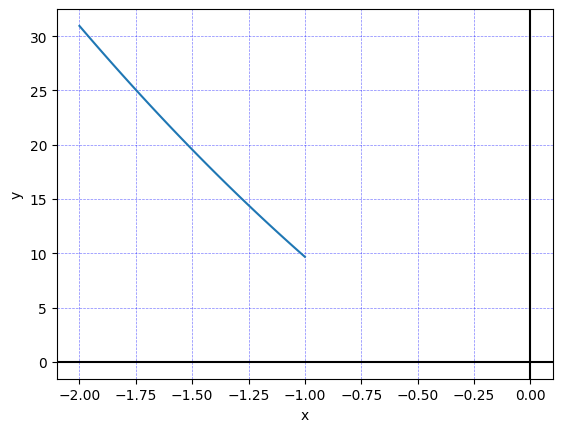

In [5]:
print('3. predpoklad pre Newtonovu metodu - derivacia nemoze byt na intervali blizka 0')
plot_fn_diff(f, x, x_axis=(-2, -1, 100))

Ako vidime derivacia nema hodnoty blizke 0, preto je bezpecne pouzit Newtonovu metodu. **Tiez derivacia nepretina x-ovu os v blizkosti korena, preto ide o jednoduchy koren.**

Mozeme ist pocitat. **Ako startovaci bod zvolime x0 = -2**, kedze tento je v tej casti funkcie ktora splna vsetky potrebne predpoklady (opisane vyssie).

In [15]:
print('4. Newtonova metoda')
newtonova_metoda(f, x, x=[-2])

print('\n5. FindRoot - Newton')
print(findroot(lambda x: 12.723489 - 5.589489*x - 6.134*x**2 + x**3, -2, solver='newton'))

4. Newtonova metoda
     i      x(i)  |x(i+1)-x(i)|
0  0.0 -2.000000   2.789824e-01
1  1.0 -1.721018   2.789824e-01
2  2.0 -1.683217   3.780021e-02
3  3.0 -1.682535   6.828493e-04
4  4.0 -1.682534   2.214702e-07
5  5.0 -1.682534   2.331468e-14

SKUSKA: -0.0000000000000071

5. FindRoot - Newton
-1.68253428396731


Ako vidime ziskali sme priblizny vysledok **x = -1.682534** s presnostou 10^-11 co je lepsie ako pozadovana presnost. Ako vidime vysledok sa zhoduje s vysledkom vypocitanym standardnou Python kniznicou mpmath (tiez s pouzitim newtonovej metody)

Priklad **zleho pociatocneho** bodu x=-0.2, tento bod je v blilzkosti lokalneho extremu, co sa nam premietne do vyrazne nepresnejsieho vysledku.

In [7]:
print('4. Newtonova metoda - zly bod')
newtonova_metoda(f, x, x=[-0.2])

4. Newtonova metoda - zly bod
     i       x(i)  |x(i+1)-x(i)|
0  0.0  -0.200000       4.505480
1  1.0   4.305480       4.505480
2  2.0 -11.864361      16.169841
3  3.0  -7.498940       4.365421
4  4.0  -4.707995       2.790945
5  5.0  -3.011806       1.696190
6  6.0  -2.100053       0.911753
7  7.0  -1.745243       0.354810
8  8.0  -1.684316       0.060927
9  9.0  -1.682536       0.001780

SKUSKA: -0.0000000000253362


### 3. Hladanie najvacsieho korena (na intervale [6, 7.5]), pomocou Newtonovej metody.
Pre pouzitie Newtonovej metody je potrebne, aby interval na ktorom hladame koren bol:
- monotony
- bez inflexnych bodov
- bez extremov

Z obrazkov uvedenych vyssie v casti 1. Separacia korenov vidime, ze to interval [6, 7.5] splna.

Dalsim predpodkladom musi byt ze derivacia funckie (kedze je v menovatelovi) nemoze mat hodnoty blizke nule na danom intervale. Overime to nakreslenim prvej derivacie funkcie:

3. predpoklad pre Newtonovu metodu - derivacia nemoze byt na intervali blizka 0


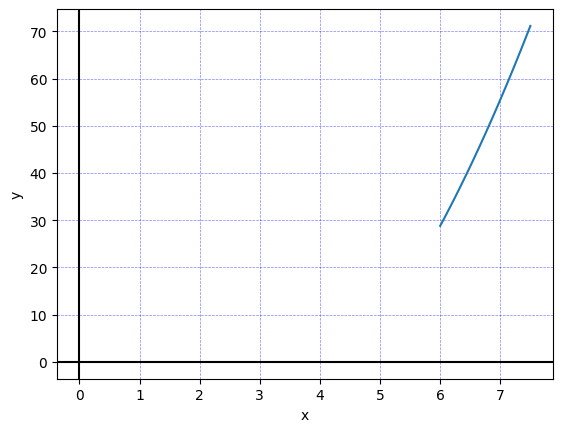

In [8]:
print('3. predpoklad pre Newtonovu metodu - derivacia nemoze byt na intervali blizka 0')
plot_fn_diff(f, x, x_axis=(6, 7.5, 100))

Ako vidime derivacie nema hodnoty blizke 0, preto je bezpecne pouzit Newtonovu metodu. Tiez derivacia nepretina x-ovu os v blizkosti korena, preto ide o jednoduchy koren.

Mozeme ist pocitat. **Ako startovaci bod zvolime x0 = 7.5**, kedze tento je v tej casti funkcie ktora splna vsetky potrebne predpoklady (opisane vyssie).

In [16]:
print('4. Newtonova metoda')
newtonova_metoda(f, x, x=[7.5])

print('\n5. FindRoot - Newton')
print(findroot(lambda x: 12.723489 - 5.589489*x - 6.134*x**2 + x**3, 7.5, solver='newton'))

4. Newtonova metoda
     i      x(i)  |x(i+1)-x(i)|
0  0.0  7.500000   6.695640e-01
1  1.0  6.830436   6.695640e-01
2  2.0  6.691309   1.391274e-01
3  3.0  6.685408   5.900495e-03
4  4.0  6.685398   1.043774e-05
5  5.0  6.685398   3.263345e-11

SKUSKA: 0.0000000000000284

5. FindRoot - Newton
6.6853977004069


Ako vidime ziskali sme priblizny vysledok **x = 6.685398** s presnostou 10^-11 co je lepsie ako pozadovana presnost. Ako vidime vysledok sa zhoduje s vysledkom vypocitanym standardnou Python kniznicou mpmath (tiez s pouzitim newtonovej metody)

Priklad **zleho pociatocneho** bodu x=4.5, tento bod je v blilzkosti lokalneho extremu, co sa nam premietne do nezmyseslneho vysledku.

In [10]:
print('4. Newtonova metoda - zly bod')
newtonova_metoda(f, x, x=[4.5])

4. Newtonova metoda - zly bod
     i        x(i)  |x(i+1)-x(i)|
0  0.0    4.500000    1000.631175
1  1.0 -996.131175    1000.631175
2  2.0 -663.409925     332.721249
3  3.0 -441.597771     221.812154
4  4.0 -293.726014     147.871757
5  5.0 -195.149351      98.576663
6  6.0 -129.438312      65.711039
7  7.0  -85.641003      43.797309
8  8.0  -56.457748      29.183255
9  9.0  -37.024396      19.433352

SKUSKA: -17415.7288337263198628


## Priklad 2

### 1. Nakres sustavy rovnic

Cely system na intervale [-10, 10]


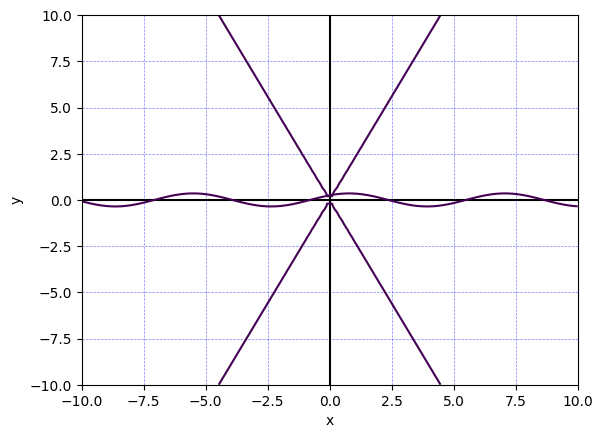

Zacielene na korene


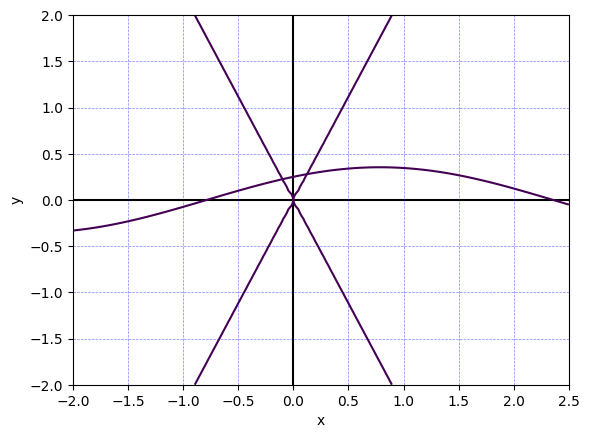

In [11]:
_vars = {'x': 0, 'y': 0}
_funcs = ['5*x**2-y**2', 'y-0.25*(sin(x)+cos(x))']

print('Cely system na intervale [-10, 10]')
plot_fn_system(_vars, _funcs, x_axis=(-10, 10), y_axis=(-10, 10))

print('Zacielene na korene')
plot_fn_system(_vars, _funcs, x_axis=(-2, 2.5), y_axis=(-2, 2))

### 2. Vypocet:

Vypocet budeme realizovat pomocou:

**1. metoda vypoctu pomocou cislenej inverznej matice:** tato metoda hoci ma nevyhodu v tom, ze pocita inverznu maticu v kazdej iteracii, cim sa prenasa a duplikuje chyba, v nasom pripade je mozne ju vyuzit lebo potrebujeme iba 6 iteracii. Navyse tato metoda je robustnejsia (nespolieha sa na kniznicu pri vypocte inverznej matice vo forme predpisu funkcie - pismenkovej). Tato metoda je vhodnejsia pre Python kedze ten nema taky vykonny engine pre vypocet inverznej matice vo forme predpisu funkcie ako ma Mathematica.

**Startovacie body sme zvolili {0.25, 0.1} pre vypocet vacsieho korena a {-0.25, 0.1} pre vypocet mensieho korena**. V okoli tychto bodov sa nenachadzaju ziadne extremy ani inflexne body, tiez su tu obe funkcie monotonne.

In [12]:
print('Vacsi koren:')
_vars = {'x': 0.25, 'y': 0.1}
inv_sustava_rovnic(_vars, _funcs)

print('Mensi koren:')
_vars = {'x': -0.25, 'y': 0.1}
inv_sustava_rovnic(_vars, _funcs)

Vacsi koren:
       x(i)      y(i)           err
0  0.250000  0.100000  1.849219e-01
1  0.143794  0.284922  1.757950e-02
2  0.126214  0.279525  1.349966e-03
3  0.124864  0.279189  8.107487e-06
4  0.124856  0.279187  2.924568e-10
5  0.124856  0.279187  2.775558e-17
SKUSKA F1: -0.0000000000000000
SKUSKA F2: 0.0000000000000000


Mensi koren:
       x(i)      y(i)           err
0 -0.250000  0.100000  1.143880e-01
1 -0.138151  0.214388  3.326576e-02
2 -0.104885  0.222573  4.712641e-03
3 -0.100173  0.223748  9.853079e-05
4 -0.100074  0.223772  4.311394e-08
5 -0.100074  0.223772  8.257284e-15
6 -0.100074  0.223772  0.000000e+00
SKUSKA F1: 0.0000000000000000
SKUSKA F2: 0.0000000000000000




Co sa tyka zlej volby bodu, tak by sme ocakavali ze bude niekde v okoli x=0 (inflexny bod) alebo x=0.75 (lokalny extrem) ale sustavu je mozne uspesne vypocitat v oboch pripadoch, zmeni sa iba pocet iteracii.

In [13]:
print('Zly bod:')
_vars = {'x': 0, 'y': 0.1}
inv_sustava_rovnic(_vars, _funcs)

_vars = {'x': 0.75, 'y': 0.1}
inv_sustava_rovnic(_vars, _funcs)

Zly bod:
       x(i)      y(i)           err
0  0.000000  0.100000  8.000000e-01
1 -0.800000  0.050000  3.986156e-01
2 -0.401384  0.135755  1.920651e-01
3 -0.209319  0.195417  8.238222e-02
4 -0.126937  0.217020  2.427685e-02
5 -0.102660  0.223128  2.557209e-03
6 -0.100103  0.223765  2.903117e-05
7 -0.100074  0.223772  3.742873e-09
8 -0.100074  0.223772  5.551115e-17
SKUSKA F1: 0.0000000000000001
SKUSKA F2: 0.0000000000000000


       x(i)      y(i)           err
0  0.750000  0.100000  3.670336e-01
1  0.382966  0.348739  1.682362e-01
2  0.214730  0.302013  6.990440e-02
3  0.144826  0.284179  1.846303e-02
4  0.126363  0.279561  1.496606e-03
5  0.124866  0.279189  9.964546e-06
6  0.124856  0.279187  4.417779e-10
7  0.124856  0.279187  0.000000e+00
SKUSKA F1: 0.0000000000000000
SKUSKA F2: 0.0000000000000000




**2. metoda vypoctu pomocou metody CHORD:** kde fixujeme inverznu maticu na pociatocny bod x0. Vyhodou teda je ze sa ciselna inverzna matica vypocita iba raz, co proces znacne zrychli. Nevyhodou je ze tento vysledok bude menej presny. Ale svojim profilom je vhodna pre Python.

In [14]:
print('Vacsi koren:')
_vars = {'x': 0.25, 'y': 0}
chord_sustava_rovnic(_vars, _funcs, r=25)

Vacsi koren:
        x(i)      y(i)           err
0   0.250000  0.000000  2.815320e-01
1   0.125000  0.281532  2.231947e-03
2   0.125454  0.279300  2.740629e-04
3   0.125180  0.279267  1.440317e-04
4   0.125036  0.279231  7.998709e-05
5   0.124956  0.279211  4.439115e-05
6   0.124912  0.279201  2.464804e-05
7   0.124887  0.279194  1.368911e-05
8   0.124873  0.279191  7.603741e-06
9   0.124866  0.279189  4.223888e-06
10  0.124861  0.279188  2.346475e-06
11  0.124859  0.279188  1.303556e-06
12  0.124858  0.279187  7.241839e-07
13  0.124857  0.279187  4.023197e-07
14  0.124857  0.279187  2.235092e-07
15  0.124856  0.279187  1.241711e-07
16  0.124856  0.279187  6.898368e-08
17  0.124856  0.279187  3.832413e-08
18  0.124856  0.279187  2.129112e-08
19  0.124856  0.279187  1.182837e-08
20  0.124856  0.279187  6.571297e-09
21  0.124856  0.279187  3.650711e-09
22  0.124856  0.279187  2.028167e-09
23  0.124856  0.279187  1.126757e-09
24  0.124856  0.279187  6.259743e-10
SKUSKA F1: 0.000000000869

Ako vidime fixovanie inverznej matice v tomto pripade vypocet dost znepresni, je potrebnych az 25 iteracii, aby sa dostali do pozadovanej presnosti.